In [59]:
!open ./

In [2]:
from __future__ import division
import os

import numpy as np
from numpy import pi

import pandas as pd
from numpy import sqrt
from scipy import integrate

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def journal():
    '''
    Appears nearly square. I like this best.
    'figure.figsize': [3.1, 2.6]
    
    Use: plt.tight_layout(pad=0.1, w_pad=0.0, h_pad=0.0)
    plt.xlabel('$E_{iso}$ $(erg)$',labelpad=-1)  
    plt.ylabel('$E^*_{pk}$ $(keV)$',labelpad=-2)
    
    '''
    params = {'backend': 'pdf',
              'axes.labelsize':  10,
              'font.size':       10,
              'legend.fontsize': 8,
              'xtick.labelsize': 8,
              'ytick.labelsize': 8,
              'xtick.direction': 'in',
              'ytick.direction': 'in',
              'text.usetex':     True,
              'figure.figsize': [4,3], #[4,3], #[3.1, 2.6], # [7,6]
              'font.family': 'serif',}
    plt.rcParams.update(params)

In [4]:
journal()

#### All luminosity distance functions must pass results in parsecs.

In [5]:
def LumDist_concordance(redshift, H_knot, omega_m):
    """
    This is the function we use in our work, but different cosmo constants 
    as well as DL units. 
    """
    z           = redshift
    omega_l     = 1.0 - omega_m
    
    c           = 2.99792458e5      # SPEED OF LIGHT    Units: km/s
    def Aint(z):
        return (1./(sqrt(((1.+z)*(1.+z)*(1. + omega_m * z))-(z*(2.+ z)*omega_l ))))
    AA      = integrate.quad(Aint, 0.0, z)
    DL_Mpc  = (c * (1. + z) / H_knot) * AA[0]
    DL_pc = DL_Mpc * (1E6) # convert Mpc to pc
    return DL_pc


def LumDist_riess(redshift, H_knot, omega_m):
    """
    Lower order expansion for dark energy term (w). Equation 14 in Riess et al. 2004. 
    w(z) = w0 + w'z
    """
    z           = redshift
    omega_l     = 1.0 - omega_m
    c           = 2.99792458e5      # SPEED OF LIGHT    Units: km/s
    w0 = -1.31
    wp = 1.48   # p: prime symbol
    def Aint(z):
        return 1./np.sqrt( ((1.+z)**3)*omega_m + \
                         omega_l*((1.+z)**(3*(1+w0-wp)))*np.exp(3*wp*z) )
    AA      = integrate.quad(Aint, 0.0, z)
    DL_Mpc  = (c * (1. + z) / H_knot) * AA[0]
    DL_pc = DL_Mpc * (1E6) # convert Mpc to pc
    return DL_pc


def LumDist_weylgravity(redshift, H_knot):
    """
    Weyl Gravity.
    Equation 237 in Mannheim 2006 paper
    q_knot      = -0.37 or -0.2
    """
    z           = redshift
    c           = 2.99792458e5      # SPEED OF LIGHT    Units: km/s
    q_knot      = -0.37
    DL_Mpc  = (-c * ((1. + z)**2) / (H_knot * q_knot)) * \
                (1-np.sqrt(1 + q_knot - (q_knot/((1+z)**2))))
    DL_pc = DL_Mpc * (1E6) # convert Mpc to pc
    return DL_pc

    
def distance_modulus(lumdistance):
    return 5*np.log10(lumdistance)-5


def get_moduli(model, redshifts=None, H_knot=None, omega_m=None):
    """
    model : str. 'concord', 'weyl', or 'riess'
                    or 'c', 'w', and 'r'
    
    """
    H0 = H_knot
    OM = omega_m
    if model.startswith('c'):   
        DLs = [LumDist_concordance(redshift=z, H_knot=H0, omega_m=OM) for z in redshifts]
    elif model.startswith('r'):   
        DLs = [LumDist_riess(redshift=z, H_knot=H0, omega_m=OM) for z in redshifts]
    elif model.startswith('w'):   
        DLs = [LumDist_weylgravity(redshift=z, H_knot=H0) for z in redshifts]
    moduli = [distance_modulus(lumdistance=dL) for dL in DLs]
    return moduli

In [58]:
LumDist_concordance(redshift=4.3, H_knot=67.8, omega_m=0.308)

39985882202.56954

In [6]:
def calc_eiso(fluence, lumdist, redshift):
    flue = fluence
    DL = lumdist 
    z = redshift
    return flue*((4.0*pi*(DL**2))/(1.0+z))

In [7]:
mu = lambda values,errors: np.nansum([i/(j**2) for i,j in zip(values,errors)])/np.nansum([(j**-2.) for j in errors])
mu_unc = lambda errors: (np.nansum([(j**-2.) for j in errors]))**-0.5

Read Data
---

In [31]:
#   The luminosity distances of these functions are in parsecs. Need to use pctocm to convert to cm.
# 1 pc = 3.0856775814914E+18 cm
Mpctocm = 3.08567758E24
pctocm = 3.08567758E18

In [8]:
filename = ('/Users/KimiZ/GRBs2/Sample/'
            'Band_13_GBM+LAT__22_GBMconstrained.txt')

df_ = pd.read_csv(filename, sep='\t')

cols2keep = ['trigger', 'name', 'number', 'z', 't90', 'detector','LATburst'] 

# Make new dataframe with only certain columns
df = pd.DataFrame(df_.loc[:, cols2keep])

# Copy over flux and fluences from 1 keV-10 MeV. 
df['flux'] = df_['Flux3']
df['flux_err_low'] = df_['Flux3']-df_['Flux3_err']  # value - margin of error
df['flux_err_up'] = df_['Flux3']+df_['Flux3_err']   # value + margin of error


df['fluence'] = df_['Flue3']
df['fluence_err_low'] = df_['Flue3']-df_['Flue3_err']  # value - margin of error
df['fluence_err_up'] = df_['Flue3']+df_['Flue3_err']   # value + margin of error

In [32]:
H_knot = 67.8
omega_m = 0.308

redshifts = df.z.values

In [33]:
# Concordance Cosmology (Lambda CDM)
df['DL1'] = np.asarray([LumDist_concordance(redshift=z, H_knot=H_knot, omega_m=omega_m) for z in redshifts])*pctocm

# Riess Cosmology
df['DL2'] = np.asarray([LumDist_riess(redshift=z, H_knot=H_knot, omega_m=omega_m) for z in redshifts])*pctocm

# Weyl Gravity
df['DL3'] = np.asarray([LumDist_weylgravity(redshift=z, H_knot=H_knot) for z in redshifts])*pctocm

In [34]:
# Concordance Cosmology (Lambda CDM)
df['eiso1']         = calc_eiso(fluence=df.fluence, lumdist=df['DL1'], redshift=df.z)
df['eiso1_err_low'] = calc_eiso(fluence=df.fluence_err_low, lumdist=df['DL1'], redshift=df.z)
df['eiso1_err_up']  = calc_eiso(fluence=df.fluence_err_up, lumdist=df['DL1'], redshift=df.z)
df['eiso1_err']     = df['eiso1']-df['eiso1_err_low']  # margin of error. Eiso errs should be symmetrical when unlogged

# Riess Cosmology
df['eiso2']         = calc_eiso(fluence=df.fluence, lumdist=df['DL2'], redshift=df.z)
df['eiso2_err_low'] = calc_eiso(fluence=df.fluence_err_low, lumdist=df['DL2'], redshift=df.z)
df['eiso2_err_up']  = calc_eiso(fluence=df.fluence_err_up, lumdist=df['DL2'], redshift=df.z)
df['eiso2_err']     = df['eiso2']-df['eiso2_err_low']  # margin of error. Eiso errs should be symmetrical when unlogged


# Weyl Gravity
df['eiso3']         = calc_eiso(fluence=df.fluence, lumdist=df['DL3'], redshift=df.z)
df['eiso3_err_low'] = calc_eiso(fluence=df.fluence_err_low, lumdist=df['DL3'], redshift=df.z)
df['eiso3_err_up']  = calc_eiso(fluence=df.fluence_err_up, lumdist=df['DL3'], redshift=df.z)
df['eiso3_err']     = df['eiso3']-df['eiso3_err_low']  # margin of error. Eiso errs should be symmetrical when unlogged


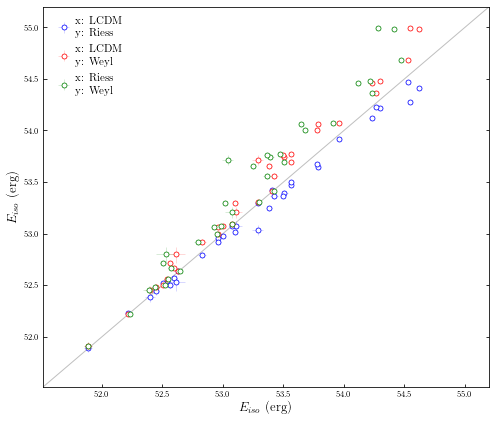

In [35]:
axLims = (51.51, 55.2)


plt.clf()
plt.figure(figsize=(8,7))
#plt.figure()


xaxis = 'eiso1'
yaxis = 'eiso2'
pltKwgs = dict(fmt='o', color='white', ecolor='blue', ms=5, lw=0.6, mec='blue', mew=0.75,
               capsize=0, alpha=1, label='x: LCDM\ny: Riess')
x = df[xaxis].apply(np.log10)
y = df[yaxis].apply(np.log10)
xerr = np.asarray([(df[xaxis].apply(np.log10)-df[xaxis+'_err_low'].apply(np.log10)).values, # lower margin of error
                   (df[xaxis+'_err_up'].apply(np.log10)-df[xaxis].apply(np.log10)).values]) # upper margin of error
yerr = np.asarray([(df[yaxis].apply(np.log10)-df[yaxis+'_err_low'].apply(np.log10)).values, # lower margin of error
                   (df[yaxis+'_err_up'].apply(np.log10)-df[yaxis].apply(np.log10)).values]) # upper margin of error
#plt.errorbar(x=x, y=y, yerr=yerr, xerr=xerr, **pltKwgs)
markers, caps, bars = plt.errorbar(x=x, y=y, yerr=yerr, xerr=xerr, **pltKwgs)
[bar.set_alpha(0.25) for bar in bars]
[cap.set_alpha(0.25) for cap in caps]


xaxis = 'eiso1'
yaxis = 'eiso3'
pltKwgs = dict(fmt='o', color='white', ecolor='red', ms=5, lw=0.6, mec='red', mew=0.75,
               capsize=0, alpha=1, label='x: LCDM\ny: Weyl')
x = df[xaxis].apply(np.log10)
y = df[yaxis].apply(np.log10)
xerr = np.asarray([(df[xaxis].apply(np.log10)-df[xaxis+'_err_low'].apply(np.log10)).values, # lower margin of error
                   (df[xaxis+'_err_up'].apply(np.log10)-df[xaxis].apply(np.log10)).values]) # upper margin of error
yerr = np.asarray([(df[yaxis].apply(np.log10)-df[yaxis+'_err_low'].apply(np.log10)).values, # lower margin of error
                   (df[yaxis+'_err_up'].apply(np.log10)-df[yaxis].apply(np.log10)).values]) # upper margin of error
#plt.errorbar(x=x, y=y, yerr=yerr, xerr=xerr, **pltKwgs)
markers, caps, bars = plt.errorbar(x=x, y=y, yerr=yerr, xerr=xerr, **pltKwgs)
[bar.set_alpha(0.25) for bar in bars]
[cap.set_alpha(0.25) for cap in caps]
    

xaxis = 'eiso2'
yaxis = 'eiso3'
pltKwgs = dict(fmt='o', color='white', ecolor='green', ms=5, lw=0.6, mec='green', mew=0.75,
               capsize=0, alpha=1, label='x: Riess\ny: Weyl')
x = df[xaxis].apply(np.log10)
y = df[yaxis].apply(np.log10)
xerr = np.asarray([(df[xaxis].apply(np.log10)-df[xaxis+'_err_low'].apply(np.log10)).values, # lower margin of error
                   (df[xaxis+'_err_up'].apply(np.log10)-df[xaxis].apply(np.log10)).values]) # upper margin of error
yerr = np.asarray([(df[yaxis].apply(np.log10)-df[yaxis+'_err_low'].apply(np.log10)).values, # lower margin of error
                   (df[yaxis+'_err_up'].apply(np.log10)-df[yaxis].apply(np.log10)).values]) # upper margin of error
#plt.errorbar(x=x, y=y, yerr=yerr, xerr=xerr, **pltKwgs)
markers, caps, bars = plt.errorbar(x=x, y=y, yerr=yerr, xerr=xerr, **pltKwgs)
[bar.set_alpha(0.25) for bar in bars]
[cap.set_alpha(0.25) for cap in caps]
#[marker.set_alpha(0.25) for marker in markers]


# Plot a line at equal values of x and y 
xlinedata = np.linspace(axLims[0], axLims[1], 10)
ylinedata = 1.0*xlinedata+0
plt.plot(xlinedata, ylinedata, 'k-', lw=1, alpha=0.25) 

plt.xlim(*axLims)
plt.ylim(*axLims)
plt.legend(loc=0, fontsize=11, labelspacing=0.7, handletextpad=0, frameon=False)
plt.xlabel('$E_{iso}$ (erg)', fontsize=13)
plt.ylabel('$E_{iso}$ (erg)', fontsize=13)
plt.show()


In [36]:
df['diff_1v2'] = (df['eiso1'].apply(np.log10) - df['eiso2'].apply(np.log10)).apply(abs)

df['diff_1v3'] = (df['eiso1'].apply(np.log10) - df['eiso3'].apply(np.log10)).apply(abs)

df['diff_2v3'] = (df['eiso2'].apply(np.log10) - df['eiso3'].apply(np.log10)).apply(abs)

In [37]:
sort_by = 'diff_1v2'

kim = df.sort_values(by=sort_by).loc[:, ['z',sort_by]]

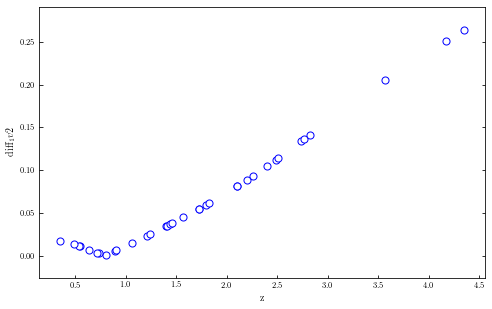

In [38]:
plt.clf()
(kim).plot(kind='scatter', x='z', y=sort_by, figsize=(8,5),
                                                        marker='o', s=50, color='white', edgecolor='blue')

In [39]:
kim.min()

z           0.347000
diff_1v2    0.000832
dtype: float64

In [40]:
kim

,z,diff_1v2
23,0.8040,0.000832
2,0.7360,0.002613
26,0.7160,0.003599
6,0.8969,0.005724
3,0.9030,0.006051
12,0.6420,0.007101
16,0.5440,0.011268
17,0.5400,0.011423
19,0.4900,0.013237
7,1.0633,0.014846


In [41]:
df.sort_values(by='z').loc[:, ['z', 'number', 'LATburst']]

,z,number,LATburst
32,0.3470,62,N
19,0.4900,27,N
17,0.5400,19,N
16,0.5440,16,N
12,0.6420,66,Y
26,0.7160,45,N
2,0.7360,14,Y
23,0.8040,36,N
6,0.8969,24,Y
3,0.9030,17,Y


In [42]:
sort_by = 'diff_1v3'

kim2 = df.sort_values(by=sort_by).loc[:, ['z',sort_by]]

In [43]:
plt.clf()

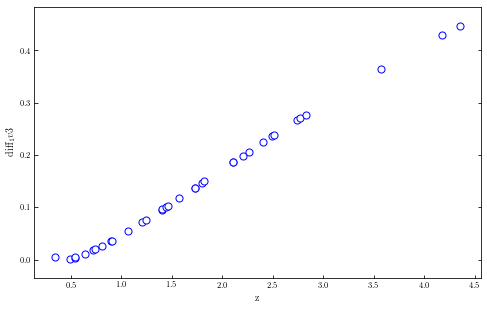

In [44]:
(kim2).plot(kind='scatter', x='z', y=sort_by, figsize=(8,5),
                                                        marker='o', s=50, color='white', edgecolor='blue')

In [45]:
kim2.min()

z           0.347000
diff_1v3    0.001059
dtype: float64

In [46]:
kim2

,z,diff_1v3
19,0.4900,0.001059
17,0.5400,0.004233
16,0.5440,0.004504
32,0.3470,0.005527
12,0.6420,0.011858
26,0.7160,0.018219
2,0.7360,0.020043
23,0.8040,0.026539
6,0.8969,0.036060
3,0.9030,0.036708


In [47]:
df.sort_values(by='z').loc[:, ['z', 'number', 'LATburst']]

,z,number,LATburst
32,0.3470,62,N
19,0.4900,27,N
17,0.5400,19,N
16,0.5440,16,N
12,0.6420,66,Y
26,0.7160,45,N
2,0.7360,14,Y
23,0.8040,36,N
6,0.8969,24,Y
3,0.9030,17,Y


In [48]:
sort_by = 'diff_2v3'

kim3 = df.sort_values(by=sort_by).loc[:, ['z',sort_by]]

In [49]:
plt.clf()

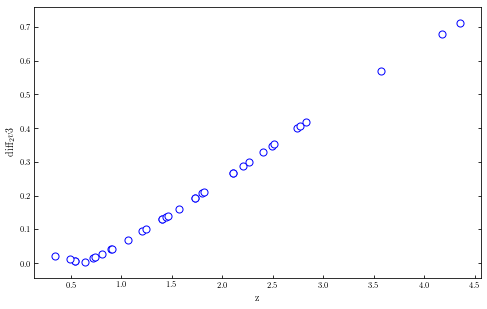

In [50]:
(kim3).plot(kind='scatter', x='z', y=sort_by, figsize=(8,5),
                                                        marker='o', s=50, color='white', edgecolor='blue')

In [51]:
kim3.min()

z           0.347000
diff_2v3    0.004756
dtype: float64

In [52]:
kim3

,z,diff_2v3
12,0.6420,0.004756
16,0.5440,0.006764
17,0.5400,0.007190
19,0.4900,0.012178
26,0.7160,0.014621
2,0.7360,0.017430
32,0.3470,0.022202
23,0.8040,0.027371
6,0.8969,0.041784
3,0.9030,0.042759


In [53]:
df.sort_values(by='z').loc[:, ['z', 'number', 'LATburst']]

,z,number,LATburst
32,0.3470,62,N
19,0.4900,27,N
17,0.5400,19,N
16,0.5440,16,N
12,0.6420,66,Y
26,0.7160,45,N
2,0.7360,14,Y
23,0.8040,36,N
6,0.8969,24,Y
3,0.9030,17,Y


In [54]:
df.diff_1v2

0     0.263978
1     0.205058
2     0.002613
3     0.006051
4     0.061396
5     0.081850
6     0.005724
7     0.014846
8     0.044644
9     0.141572
10    0.112456
11    0.105009
12    0.007101
13    0.114297
14    0.093735
15    0.136357
16    0.011268
17    0.011423
18    0.024910
19    0.013237
20    0.034240
21    0.081835
22    0.036781
23    0.000832
24    0.054991
25    0.038001
26    0.003599
27    0.055057
28    0.059759
29    0.034662
30    0.251672
31    0.089033
32    0.016675
33    0.133758
34    0.023037
Name: diff_1v2, dtype: float64

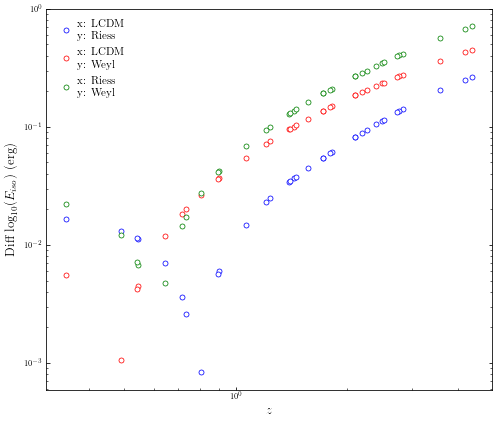

In [55]:
#axLims = (51.51, 55.2)


plt.clf()
plt.figure(figsize=(8,7))
#plt.figure()

pltKwgs = dict(fmt='o', color='white', ecolor='blue', ms=5, lw=0.6, mec='blue', mew=0.75,
               capsize=0, alpha=1, label='x: LCDM\ny: Riess')
plt.errorbar(x=df['z'], y=df['diff_1v2'], **pltKwgs)


pltKwgs = dict(fmt='o', color='white', ecolor='red', ms=5, lw=0.6, mec='red', mew=0.75,
               capsize=0, alpha=1, label='x: LCDM\ny: Weyl')
plt.errorbar(x=df['z'], y=df['diff_1v3'], **pltKwgs)


pltKwgs = dict(fmt='o', color='white', ecolor='green', ms=5, lw=0.6, mec='green', mew=0.75,
               capsize=0, alpha=1, label='x: Riess\ny: Weyl')
plt.errorbar(x=df['z'], y=df['diff_2v3'], **pltKwgs)


# plt.xlim(*axLims)
# plt.ylim(*axLims)
plt.legend(loc=0, fontsize=11, labelspacing=0.7, handletextpad=0, frameon=False)
plt.ylabel('Diff $\log_{10}$($E_{iso}$) (erg)', fontsize=13)
plt.xlabel('$z$', fontsize=13)
plt.yscale('log')
plt.xscale('log')
plt.show()

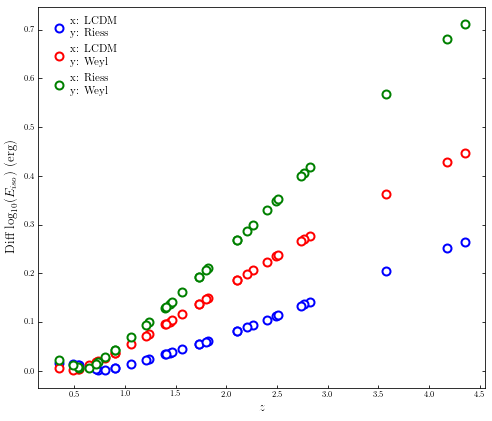

In [57]:
xLims = (None, None)
yLims = (None, None)

# xLims = (0.2, 1)
# yLims = (-0.001, .05)


plt.clf()
plt.figure(figsize=(8,7))
#plt.figure()

plt.plot(df['z'], df['diff_1v2'], marker='o', ms=8, color='white', mec='blue', mew=2, lw=0,  label='x: LCDM\ny: Riess')

plt.plot(df['z'], df['diff_1v3'], marker='o', ms=8, color='white', mec='red', mew=2, lw=0, label='x: LCDM\ny: Weyl')

plt.plot(df['z'], df['diff_2v3'], marker='o', ms=8, color='white', mec='green', mew=2, lw=0, label='x: Riess\ny: Weyl')


plt.xlim(*xLims)
plt.ylim(*yLims)
plt.legend(loc=0, fontsize=11, labelspacing=0.7, handletextpad=0, frameon=False)
plt.ylabel('Diff $\log_{10}$($E_{iso}$) (erg)', fontsize=13)
plt.xlabel('$z$', fontsize=13)
#plt.yscale('log')
#plt.xscale('log')
plt.show()